In [23]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

In [24]:
np.__version__, torch.__version__

('1.21.6', '1.13.1+cu116')

In [25]:
import matplotlib
matplotlib.__version__

'3.2.2'

## 1. Load Data

In [26]:
corpus = ["apple banana fruit", "banana apple fruit", "banana fruit apple", "grape apple apple", 
          "dog cat animal", "cat dog animal", "cat animal dog", "fish dog dog"]

In [27]:
# 1. tokenize

corpus_tokenized = [sent.split(" ") for sent in corpus]
corpus_tokenized

[['apple', 'banana', 'fruit'],
 ['banana', 'apple', 'fruit'],
 ['banana', 'fruit', 'apple'],
 ['grape', 'apple', 'apple'],
 ['dog', 'cat', 'animal'],
 ['cat', 'dog', 'animal'],
 ['cat', 'animal', 'dog'],
 ['fish', 'dog', 'dog']]

In [28]:
# 2. numericalize
# 2.1 get all the unique words
flatten = lambda l: [item for sublist in l for item in sublist]
vocabs = list(set(flatten(corpus_tokenized)))
vocabs

['banana', 'fruit', 'dog', 'grape', 'animal', 'apple', 'fish', 'cat']

In [29]:
# 2.2 assign id to all these vocabs
word2index = {v: idx for idx, v in enumerate(vocabs)}
word2index

{'banana': 0,
 'fruit': 1,
 'dog': 2,
 'grape': 3,
 'animal': 4,
 'apple': 5,
 'fish': 6,
 'cat': 7}

In [30]:
word2index['dog']

2

In [31]:
# add <UNK>
vocabs.append('<UNK>')

In [32]:
word2index['<UNK>'] = 6

In [33]:
word2index

{'banana': 0,
 'fruit': 1,
 'dog': 2,
 'grape': 3,
 'animal': 4,
 'apple': 5,
 'fish': 6,
 'cat': 7,
 '<UNK>': 6}

In [34]:
# create index2word dictionary
index2word = {v:k for k, v in word2index.items()}
index2word

{0: 'banana',
 1: 'fruit',
 2: 'dog',
 3: 'grape',
 4: 'animal',
 5: 'apple',
 6: '<UNK>',
 7: 'cat'}

In [35]:
index2word[1]

'fruit'

## 2. Prepare Train Data

In [82]:
#move along the corpus
#to fit with our corpus, we gonna use window_size = 1

skipgrams = []

#for each corpus
for sent in corpus_tokenized:
    #for each sent ["apple", "banana", "fruit"]
    for i in range(1, len(sent) - 1): #start from 1 to second last
        center_word = sent[i]
        outside_words = [sent[i-1], sent[i+1]]  #window_size = 1
        for o in outside_words:
            skipgrams.append([center_word, o])

skipgrams
        
#here we want to create (banana, apple), (banana, fruit) append to some list

[['banana', 'apple'],
 ['banana', 'fruit'],
 ['apple', 'banana'],
 ['apple', 'fruit'],
 ['fruit', 'banana'],
 ['fruit', 'apple'],
 ['apple', 'grape'],
 ['apple', 'apple'],
 ['cat', 'dog'],
 ['cat', 'animal'],
 ['dog', 'cat'],
 ['dog', 'animal'],
 ['animal', 'cat'],
 ['animal', 'dog'],
 ['dog', 'fish'],
 ['dog', 'dog']]

In [83]:
def random_batch(batch_size, corpus):
    
    skipgrams = []

    #for each corpus
    for sent in corpus_tokenized:
        #for each sent ["apple", "banana", "fruit"]
        for i in range(1, len(sent) - 1): #start from 1 to second last
            center_word = word2index[sent[i]]
            outside_words = [word2index[sent[i-1]], word2index[sent[i+1]]]  #window_size = 1
            for o in outside_words:
                skipgrams.append([center_word, o])
                
    #only get a batch, not the entire list
    random_index = np.random.choice(range(len(skipgrams)), batch_size, replace=False)
             
    #appending some list of inputs and labels
    random_inputs, random_labels = [], []   
    for index in random_index:
        random_inputs.append([skipgrams[index][0]])  #center words, this will be a shape of (1, ) --> (1, 1) for modeling
        random_labels.append([skipgrams[index][1]])
        
    return np.array(random_inputs), np.array(random_labels)

In [84]:
random_batch(10, corpus_tokenized)

(array([[2],
        [2],
        [4],
        [5],
        [0],
        [4],
        [7],
        [2],
        [0],
        [5]]), array([[7],
        [2],
        [7],
        [1],
        [1],
        [2],
        [2],
        [4],
        [5],
        [0]]))

In [85]:
input, label = random_batch(2, corpus_tokenized)

print(f"{input=}")
print(f"{label=}")

input=array([[2],
       [5]])
label=array([[7],
       [5]])


In [86]:
input, label = random_batch(1, corpus_tokenized)

print(f"{input=}")
print(f"{label=}")

input=array([[0]])
label=array([[1]])


In [87]:
input, label = random_batch(10, corpus_tokenized)

print(f"{input.shape}")
print(f"{label=}")

(10, 1)
label=array([[2],
       [7],
       [6],
       [5],
       [4],
       [1],
       [5],
       [2],
       [5],
       [3]])


## 3. Unigram Distribution

In [88]:
z = 0.001

In [89]:
from collections import Counter

word_count = Counter(flatten(corpus_tokenized))

In [90]:
word_count

Counter({'apple': 5,
         'banana': 3,
         'fruit': 3,
         'grape': 1,
         'dog': 5,
         'cat': 3,
         'animal': 3,
         'fish': 1})

In [91]:
num_total_words = sum([c for w, c in word_count.items()])
num_total_words

24

In [92]:
unigram_table = []

for v in vocabs:
    uw = word_count[v]/num_total_words
    uw_alpha = uw ** 0.75
    uw_alpha_dividebyz = int(uw_alpha / z)
    # print("vocab: ", v)
    # print("distribution: ", uw_alpha_dividebyz)
    unigram_table.extend([v] * uw_alpha_dividebyz)
    
Counter(unigram_table)

Counter({'banana': 210,
         'fruit': 210,
         'dog': 308,
         'grape': 92,
         'animal': 210,
         'apple': 308,
         'fish': 92,
         'cat': 210})

In [93]:
word_count

Counter({'apple': 5,
         'banana': 3,
         'fruit': 3,
         'grape': 1,
         'dog': 5,
         'cat': 3,
         'animal': 3,
         'fish': 1})

## 4. Negative Sampling

In [94]:
def prepare_sequence(seq, word2index):
    # map(function, list of something)
    # map will look at each of element in this list, and apply this function
    idxs = list(map(lambda w: word2index[w] if word2index.get(w) is not None else word2index["<UNK>"], seq))
    return torch.LongTensor(idxs)

In [118]:
import random
#you don't want to pick samples = targets, basically negative samples
#k = number of negative samples - how many? they found 10 is the best
#will be run during training
#after random_batch, 
def negative_sampling(targets, unigram_table, k):
    #targets is already in id.....
    #but the unigram_table is in word....
    #1. get the batch size of this targets
    batch_size = targets.shape[0]
    neg_samples = []
    #2. for each batch
    for i in range(batch_size):
        #randomly pick k negative words from unigram_table
        target_index = targets[i].item()  #looping each of the batch....
        nsample = []
        while len(nsample) < k:
            neg = random.choice(unigram_table)
            #if this word == target, skip this word
            if word2index[neg] == target_index:
                continue
            nsample.append(neg)
        #append this word to some list
        neg_samples.append(prepare_sequence(nsample, word2index).reshape(1, -1))  #because the model wants (, 1)
    return torch.cat(neg_samples)

In [119]:
batch_size = 2
input_batch, label_batch = random_batch(batch_size, corpus_tokenized)

In [120]:
input_batch, label_batch

(array([[7],
        [2]]), array([[2],
        [2]]))

In [121]:
input_batch

array([[7],
       [2]])

In [122]:
label_batch

array([[2],
       [2]])

In [123]:
input_batch = torch.LongTensor(input_batch)
label_batch = torch.LongTensor(label_batch)

In [124]:
num_neg = 5  
neg_samples = negative_sampling(label_batch, unigram_table, num_neg)

In [125]:
neg_samples

tensor([[6, 3, 1, 1, 5],
        [1, 4, 4, 0, 0]])

In [126]:
neg_samples[0].shape

torch.Size([5])

## 5. Model

In [127]:
#the model will accept three vectors - u_o, v_c, u_w
#u_o - vector for outside words
#v_c - vector for center word
#u_k - vectors of all negative samples

class SkipgramNeg(nn.Module):
    
    def __init__(self, voc_size, emb_size):
        super(SkipgramNeg, self).__init__()
        self.embedding_center_word  = nn.Embedding(voc_size, emb_size)  #is a lookup table mapping all ids in voc_size, into some vector of size emb_size
        self.embedding_outside_word = nn.Embedding(voc_size, emb_size)
        self.logsigmoid = nn.LogSigmoid()
        
    def forward(self, center_words, outside_words, negative_words):
        #center_words, outside_words: (batch_size, 1)
        #negative_words:  (batch_size, k)
        
        center_embed  = self.embedding_center_word(center_words)    #(batch_size, 1, emb_size)
        outside_embed = self.embedding_outside_word(outside_words)  #(batch_size, 1, emb_size)
        neg_embed     = self.embedding_outside_word(negative_words) #(batch_size, k, emb_size)
        
        uovc          =  outside_embed.bmm(center_embed.transpose(1, 2)).squeeze(2)  #(batch_size, 1)
        ukvc          = -neg_embed.bmm(center_embed.transpose(1, 2)).squeeze(2)  #(batch_size, k)
        ukvc_sum      =  torch.sum(ukvc, 1).view(-1, 1) #(batch_size, 1)
        
        loss = self.logsigmoid(uovc) + self.logsigmoid(ukvc_sum)  #(batch_size, 1) + (batch_size, 1)
                
        return -torch.mean(loss)  #scalar, loss should be scalar, to call backward()

In [128]:
input, label = random_batch(batch_size, corpus_tokenized)
input_tensor = torch.LongTensor(input)  
label_tensor = torch.LongTensor(label)

In [129]:
emb_size = 2 
voc_size = len(vocabs)
model = SkipgramNeg(voc_size, emb_size)

In [130]:
neg_tensor = negative_sampling(label_tensor, unigram_table, 5)

In [131]:
input_tensor.shape, label_tensor.shape

(torch.Size([2, 1]), torch.Size([2, 1]))

In [132]:
loss = model(input_tensor, label_tensor, neg_tensor)

In [133]:
loss

tensor(4.9002, grad_fn=<NegBackward0>)

## 6. Training

In [135]:
voc_size = len(vocabs)
batch_size = 2  
emb_size = 2 
model = SkipgramNeg(voc_size, emb_size)

optimizer = optim.Adam(model.parameters(), lr=0.001)

In [136]:
num_epochs = 5000
#for epoch
for epoch in range(num_epochs):

    #get random batch
    input_batch, label_batch = random_batch(batch_size, corpus)
    input_batch = torch.LongTensor(input_batch)
    label_batch = torch.LongTensor(label_batch)
    neg_batch   = negative_sampling(label_batch, unigram_table, 5)    
    
    #loss = model
    loss = model(input_batch, label_batch, neg_batch)
    
    #backpropagate
    loss.backward()
    
    #update alpha
    optimizer.step()
    
    #print epoch loss
    if (epoch + 1) % 1000 == 0:
        print(f"Epoch {epoch+1} | Loss: {loss:.6f} | Time: ??")

Epoch 1000 | Loss: 0.903080 | Time: ??
Epoch 2000 | Loss: 0.193494 | Time: ??
Epoch 3000 | Loss: 0.126719 | Time: ??
Epoch 4000 | Loss: 0.031787 | Time: ??
Epoch 5000 | Loss: 0.030371 | Time: ??


## 7. Plot the Embeddings

In [137]:
vocabs

['banana', 'fruit', 'dog', 'grape', 'animal', 'apple', 'fish', 'cat', '<UNK>']

In [138]:
banana = torch.LongTensor([word2index['banana']])
banana

tensor([0])

In [139]:
banana_center_embed = model.embedding_center_word(banana)
banana_outisde_embed = model.embedding_outside_word(banana)

banana_embed = (banana_center_embed + banana_outisde_embed) / 2
banana_embed

tensor([[-0.4406,  5.4053]], grad_fn=<DivBackward0>)

In [140]:
def get_embed(word):
    try:
        index = word2index[word]
    except:
        index = word2index['<UNK>']
    
    word = torch.LongTensor([index])

    center_embed  = model.embedding_center_word(word)
    outside_embed = model.embedding_outside_word(word)
    
    embed = (center_embed + outside_embed) / 2
    
    return  embed[0][0].item(), embed[0][1].item()

In [141]:
#find embedding of fruit, cat
print(get_embed('fruit'))
print(get_embed('cat'))

print(get_embed('chaky'))

(-1.258906364440918, 4.8684186935424805)
(0.2933844327926636, -4.069275856018066)
(-2.0254719257354736, -1.6527162790298462)


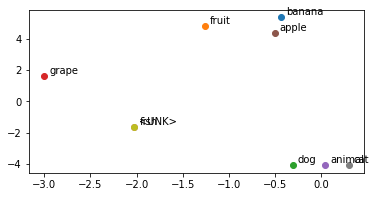

In [142]:
plt.figure(figsize=(6,3))
for i, word in enumerate(vocabs[:20]): #loop each unique vocab
    x, y = get_embed(word)
    plt.scatter(x, y)
    plt.annotate(word, xy=(x, y), xytext=(5, 2), textcoords='offset points')
plt.show()